In [1]:
import numpy as np
import pandas as pd
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from basic_functions import *
from MLP_basic_functions import *
from data_preparation import *
from eli5.permutation_importance import get_score_importances
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR


Using TensorFlow backend.


In [9]:

# dataset = pd.read_csv('July_20_WS.csv') #original dataset
# df= pd.DataFrame(dataset.iloc[:,8:13].values)

dataset = pd.read_csv('dummy_data.csv')
df= pd.DataFrame(dataset.iloc[:,1:6].values)

print(df)
z= np.abs(stats.zscore(df))
df_out = df[(z<3).all(axis=1)] #delete outliers if Z score is greater than/ less than 3,-3
X= df_out.iloc[:, 0:4].values  #z1,z2,z3,z4
y= df_out.iloc[:,-1].values.reshape((len(X),1)) #eff


#add one random column
rand_conl = np.random.random((len(X),1))
X = np.concatenate((X,rand_conl) , axis =1)

#organize the feature name
#feature_names = list(dataset.columns[8:12].values) #original dataset
feature_names = list(dataset.columns[1:5].values)
print(feature_names)
feature_names.append('Z5_RANDOM')
feature_names.append('Eff_scores')
ready_dataset = pd.DataFrame(np.concatenate((X,y),axis=1))
ready_dataset.columns = feature_names
feature_names=feature_names[0:5]
print(feature_names)


# Split the dataset into 80% trainingset and 20% testing set.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size =0.2, random_state=42)
print("train set and test set is ready")

            0         1         2         3         4
0    0.484279  0.899394  0.500304  0.735100  0.661648
1    0.576756  0.474854  0.789707  0.925661  0.965595
2    0.817715  0.990318  0.657710  0.471254  0.854535
3    0.997452  0.414087  0.885643  0.743425  0.642583
4    0.078194  0.296525  0.427189  0.527153  0.351726
..        ...       ...       ...       ...       ...
195  0.766866  0.901177  0.970795  0.029093  0.357969
196  0.350710  0.904045  0.848233  0.742234  0.000500
197  0.954296  0.644981  0.560973  0.552451  0.657307
198  0.389207  0.878880  0.947810  0.649939  0.526815
199  0.150541  0.013016  0.170284  0.792138  0.996544

[200 rows x 5 columns]
['z1_TRAF_COMP', 'z2_TRAF_DENS', 'z3_RISK_INDEX', 'z4_DELAY']
['z1_TRAF_COMP', 'z2_TRAF_DENS', 'z3_RISK_INDEX', 'z4_DELAY', 'Z5_RANDOM']
train set and test set is ready


## Random forest

In [4]:
#random forest baseline model 
rf_base_rmse, rf_base_mae = rf_base (X_train, y_train, X_test, y_test)

/Users/Georgia 1/Desktop/Machine learningOmega Paper  2020/ML2_official/A_Ranforest.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  base_model.fit(X_train, y_train)


Base model- model performance:
Evaluate the model and calculate the mean absolute error, Root mean square error
Mean Absolute Error: 0.11362
Root Mean Squarer Error: 0.14965


In [3]:
rf = RandomForestRegressor()
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start=200, stop=2000, num=10)]
#Number of features consider at every split
max_features = ['auto', 'sqrt']
#Maximum numbers of levels in tree
max_depth = [int(x) for x in np.linspace(30, 100, num=11)]
max_depth.append(None)
#Minmium number of samples require to split a node
min_samples_split = [2, 3,4]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 3]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_rf_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_rf_grid)

{'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'max_features': ['auto', 'sqrt'], 'max_depth': [30, 37, 44, 51, 58, 65, 72, 79, 86, 93, 100, None], 'min_samples_split': [2, 3, 4], 'min_samples_leaf': [1, 2, 3], 'bootstrap': [True, False]}


In [ ]:
rf_random_model = randomsearch(rf,random_rf_grid,X_train,y_train)

In [ ]:
#save random grid search model to disk
filename = 'fr_ran_search_para.sav'
pickle.dump(rf_random_model, open(filename, 'wb'))

In [ ]:
#model performance for random search Random forest model
rf_best_random = rf_random_model.best_estimator_
#training set accuracy 
print("Training set performance")
rf_ran_train_pred, rf_ran_train_errors = evaluate(rf_best_random, X_train, y_train)
print("Test set performance")
#test set accuracy 
rf_ran_pred, rf_ran_errors = evaluate(rf_best_random, X_test, y_test)

In [ ]:
# Create the parameter grid based on the results of random search
# change this depends on the result in random search
param_grid = {
    'bootstrap': [True],
    'max_depth': [45,51,56],
    'max_features': ['auto'],
    'min_samples_leaf': [1,2,3],
    'min_samples_split': [2,3],
    'n_estimators': [550,600,650]
}
# Create a based model
rf = RandomForestRegressor()

In [ ]:
#save grid search to disk
rf_grid_search = gridsearch(rf, param_grid,X_train,y_train)

best_grid = rf_grid_search.best_estimator_
# save the model to disk
filename = 'rf_grid_search_para.sav'
pickle.dump(rf_grid_search, open(filename, 'wb'))

### Reload and continued with the trained model "grid_search", the trained model is saved as 'rf_grid_search_para.sav' file.  
 (model name: rf_grid_search)

In [5]:
rf_grid_search = pickle.load(open('rf_grid_search_para.sav', 'rb'))
#show best_estimator for Random forest model 
print(rf_grid_search.best_estimator_)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=56,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=3, min_samples_split=3,
                      min_weight_fraction_leaf=0.0, n_estimators=650,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)


In [6]:
#model performance for grid search Random forest model
rf_best_grid = rf_grid_search.best_estimator_
#training set accuracy 
print("Training set performance")
rf_best_train_pred, rf_rmse_train,rf_mae_train = evaluate(rf_best_grid, X_train, y_train)

#test set accuracy 
print("Test set performance")
rf_best_pred_test, rf_rmse_test,rf_mae_test = evaluate(rf_best_grid, X_test, y_test)

Training set performance
Evaluate the model and calculate the mean absolute error, Root mean square error
Mean Absolute Error: 0.07907
Root Mean Squarer Error: 0.10658
Test set performance
Evaluate the model and calculate the mean absolute error, Root mean square error
Mean Absolute Error: 0.10801
Root Mean Squarer Error: 0.14162


### Permutation importance RF

In [8]:
print("random forest permutation importance")
rf_permu=permu_importance(rf_grid_search, X_test,y_test, feature_names,n_iter = 200)


random forest permutation importance
MSE          feature  feature_importance
0   z1_TRAF_COMP            0.019172
1   z2_TRAF_DENS            0.010856
2       z4_DELAY            0.003709
3  z3_RISK_INDEX            0.001124
4      Z5_RANDOM            0.000276
PI_std          feature  feature_importance
0   z1_TRAF_COMP            0.000816
1       z4_DELAY            0.000313
2   z2_TRAF_DENS            0.000294
3      Z5_RANDOM            0.000124
4  z3_RISK_INDEX            0.000072


## plot randomforest

Plot RF training..
estimators [2, 10, 30, 50, 100, 200, 300, 600, 800]


/opt/anaconda3/envs/ml19/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/anaconda3/envs/ml19/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/anaconda3/envs/ml19/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/anaconda3/envs/ml19/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:516: Dat

estimators: 2
MAE score: 0.12295 (+/- 0.00267)


/opt/anaconda3/envs/ml19/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/anaconda3/envs/ml19/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


estimators: 10
MAE score: 0.11053 (+/- 0.00290)


/opt/anaconda3/envs/ml19/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/anaconda3/envs/ml19/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/anaconda3/envs/ml19/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


estimators: 30
MAE score: 0.10803 (+/- 0.00275)


/opt/anaconda3/envs/ml19/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/anaconda3/envs/ml19/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/anaconda3/envs/ml19/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


estimators: 50
MAE score: 0.10763 (+/- 0.00309)


/opt/anaconda3/envs/ml19/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/anaconda3/envs/ml19/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/anaconda3/envs/ml19/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


estimators: 100
MAE score: 0.10741 (+/- 0.00288)


/opt/anaconda3/envs/ml19/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/anaconda3/envs/ml19/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/anaconda3/envs/ml19/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


estimators: 200
MAE score: 0.10711 (+/- 0.00269)


/opt/anaconda3/envs/ml19/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/anaconda3/envs/ml19/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/anaconda3/envs/ml19/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


estimators: 300
MAE score: 0.10705 (+/- 0.00298)


/opt/anaconda3/envs/ml19/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/anaconda3/envs/ml19/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/anaconda3/envs/ml19/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


estimators: 600
MAE score: 0.10700 (+/- 0.00302)


/opt/anaconda3/envs/ml19/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/anaconda3/envs/ml19/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/anaconda3/envs/ml19/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


estimators: 800
MAE score: 0.10693 (+/- 0.00291)


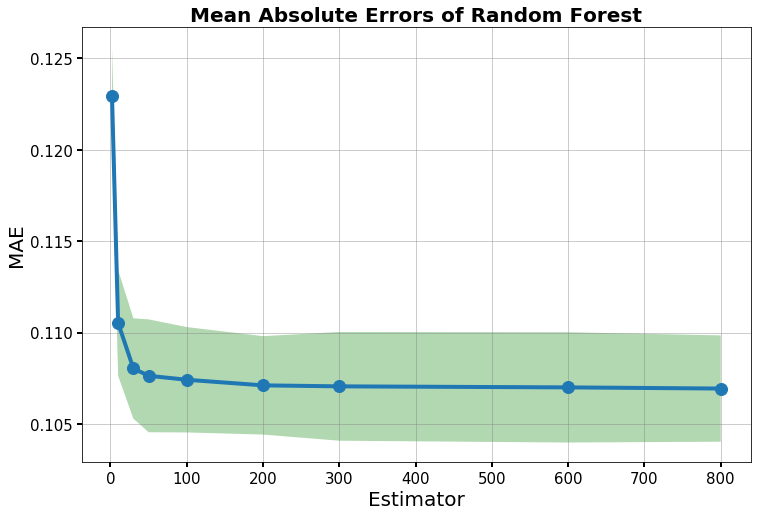

In [7]:
plot_RF_mae(y_train,X_train)

Plot RF training..
estimators [2, 10, 30, 50, 100, 200, 300, 600, 800]


/opt/anaconda3/envs/ml19/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/anaconda3/envs/ml19/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/anaconda3/envs/ml19/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/anaconda3/envs/ml19/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:516: Dat

estimators: 2
MSE score: 0.02628 (+/- 0.00151)


/opt/anaconda3/envs/ml19/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/anaconda3/envs/ml19/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


estimators: 10
MSE score: 0.02130 (+/- 0.00179)


/opt/anaconda3/envs/ml19/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/anaconda3/envs/ml19/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/anaconda3/envs/ml19/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


estimators: 30
MSE score: 0.02028 (+/- 0.00179)


/opt/anaconda3/envs/ml19/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/anaconda3/envs/ml19/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/anaconda3/envs/ml19/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


estimators: 50
MSE score: 0.02015 (+/- 0.00181)


/opt/anaconda3/envs/ml19/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/anaconda3/envs/ml19/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/anaconda3/envs/ml19/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


estimators: 100
MSE score: 0.02003 (+/- 0.00184)


/opt/anaconda3/envs/ml19/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/anaconda3/envs/ml19/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/anaconda3/envs/ml19/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


estimators: 200
MSE score: 0.01992 (+/- 0.00171)


/opt/anaconda3/envs/ml19/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/anaconda3/envs/ml19/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/anaconda3/envs/ml19/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


estimators: 300
MSE score: 0.01990 (+/- 0.00187)


/opt/anaconda3/envs/ml19/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/anaconda3/envs/ml19/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/anaconda3/envs/ml19/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


estimators: 600
MSE score: 0.01989 (+/- 0.00184)


/opt/anaconda3/envs/ml19/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/anaconda3/envs/ml19/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/anaconda3/envs/ml19/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


estimators: 800
MSE score: 0.01987 (+/- 0.00179)


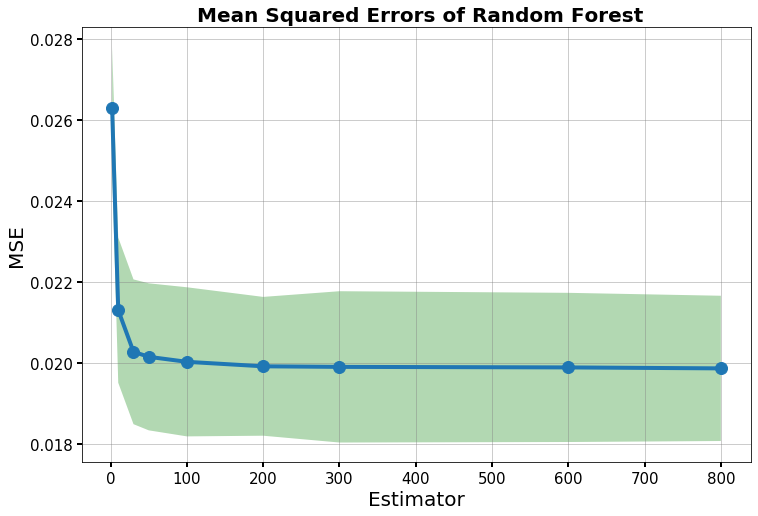

In [8]:
plot_RF_mse(y_train,X_train)

# SVM

In [12]:
X_train_sc,X_test_sc = SVM_preprocess(X_train, X_test)

In [9]:
reg = SVR()
reg.fit(X_train_sc, y_train.ravel()) 
# Predicting the Test set results
y_pred= reg.predict(X_test_sc)

In [14]:
param_grid_rbf = {'C': [0.1,1, 10,100],'gamma': [0.1,1,10,100], 'kernel':['rbf']}# ,0.3 , 0.5, 0.9]}          
parameters = {'C': [0.1,1, 10,100],'degree': [2,3,4,5], 'kernel':['poly']}# ,0.3 , 0.5, 0.9]}          

svm_random_model = randomsearch(reg,param_grid_rbf,X_train_sc,y_train.ravel())


Fitting 3 folds for each of 16 candidates, totalling 48 fits


/opt/anaconda3/envs/ml19/lib/python3.7/site-packages/sklearn/model_selection/_search.py:266: UserWarning: The total space of parameters 16 is smaller than n_iter=100. Running 16 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   25.1s
[Parallel(n_jobs=-1)]: Done  48 out of  48 | elapsed:  4.3min finished


random serach best hyperparameters {'kernel': 'rbf', 'gamma': 0.1, 'C': 10}


In [15]:
#save random grid search model to disk
filename = 'svm_ran_search_para.sav'
pickle.dump(svm_random_model, open(filename, 'wb'))

In [16]:
from sklearn.model_selection import GridSearchCV

# Create the parameter grid based on the results of random search
# change this depends on the result in random search
param_grid = {
    'C': [0.01,0.1,1],
    'gamma': [0.1,1,10],
     'kernel':['rbf']
}
# Create a based model
svr = SVR()
svm_grid_model = gridsearch(svr,param_grid,X_train_sc,y_train.ravel())
svm_best_grid = svm_grid_model.best_estimator_
print(svm_best_grid)

Fitting 3 folds for each of 9 candidates, totalling 27 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  27 out of  27 | elapsed:   30.5s finished


{'C': 1, 'gamma': 0.1, 'kernel': 'rbf'}


In [17]:
# save the model to disk
filename = 'svm_grid_search_para.sav'
pickle.dump(svm_grid_model, open(filename, 'wb'))

### Reload and continued with the trained SVM model

In [13]:
svm_grid_search = pickle.load(open('svm_grid_search_para.sav', 'rb'))


In [14]:
#model performance for grid search SVM model
svm_best_grid = svm_grid_search.best_estimator_
#training set accuracy 
print("Training set performance")
svm_best_train_pred, svm_rmse_train,svm_mae_train = evaluate(svm_grid_search, X_train_sc, y_train)
print("Test set performance")
#test set accuracy 
svr_best_pred_test, svr_rmse_test,svr_mae_test = evaluate(svm_grid_search, X_test_sc, y_test)

Training set performance
Evaluate the model and calculate the mean absolute error, Root mean square error
Mean Absolute Error: 0.1127
Root Mean Squarer Error: 0.15046
Test set performance
Evaluate the model and calculate the mean absolute error, Root mean square error
Mean Absolute Error: 0.11592
Root Mean Squarer Error: 0.15509


### Permutation importance ANN

In [24]:
print("SVM permutation importance")
svm_permu_import=permu_importance(svm_grid_search, X_test_sc,y_test, feature_names,n_iter = 200)


SVM permutation importance
MSE          feature  feature_importance
0   z1_TRAF_COMP            0.006924
1       z4_DELAY            0.001466
2   z2_TRAF_DENS            0.001349
3  z3_RISK_INDEX            0.000309
4      Z5_RANDOM           -0.000059
PI_std          feature  feature_importance
0   z1_TRAF_COMP            0.000381
1   z2_TRAF_DENS            0.000201
2       z4_DELAY            0.000122
3  z3_RISK_INDEX            0.000095
4      Z5_RANDOM            0.000062


# XGBOOST

In [15]:
dtrain= xgb.DMatrix(X_train, label=y_train, feature_names =feature_names)
dtest= xgb.DMatrix(X_test,label=y_test, feature_names =feature_names)

In [19]:
mean_train = np.mean(y_train)
# Get predictions on the test set
baseline_predictions = np.ones(y_test.shape) * mean_train
# Compute MAE
mae_baseline = mean_absolute_error(y_test, baseline_predictions)
print("Baseline MAE is {:.2f}".format(mae_baseline))

params = {
    # Parameters that we are going to tune.
    'max_depth':6,
    'min_child_weight': 1,
    'eta':.3,
    'subsample': 1,
    'colsample_bytree': 1,
    'objective':'reg:linear',
}

Baseline MAE is 0.12


In [21]:
params['eval_metric'] = ['mae','rmse']
num_boost_round = 1000

model = xgb.train(
    params,
    dtrain,
    num_boost_round=num_boost_round,
    evals=[(dtest, "Test")],
    early_stopping_rounds=10
)
print("Best MAE: {:.4f} with {} rounds".format(
                 model.best_score,
                 model.best_iteration+1))


[10:34:27] WARNING: /tmp/xgboost-20191007-44032-1f3rb3e/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	Test-mae:0.118272	Test-rmse:0.159735
Multiple eval metrics have been passed: 'Test-rmse' will be used for early stopping.

Will train until Test-rmse hasn't improved in 10 rounds.
[1]	Test-mae:0.114724	Test-rmse:0.153126
[2]	Test-mae:0.11281	Test-rmse:0.149706
[3]	Test-mae:0.111738	Test-rmse:0.147904
[4]	Test-mae:0.111216	Test-rmse:0.146904
[5]	Test-mae:0.110705	Test-rmse:0.145995
[6]	Test-mae:0.110328	Test-rmse:0.145337
[7]	Test-mae:0.110288	Test-rmse:0.14505
[8]	Test-mae:0.110317	Test-rmse:0.144881
[9]	Test-mae:0.110026	Test-rmse:0.144494
[10]	Test-mae:0.110002	Test-rmse:0.144319
[11]	Test-mae:0.109893	Test-rmse:0.144059
[12]	Test-mae:0.109975	Test-rmse:0.144121
[13]	Test-mae:0.109959	Test-rmse:0.144005
[14]	Test-mae:0.109796	Test-rmse:0.143772
[15]	Test-mae:0.109125	Test-rmse:0.142863
[16]	Test-mae:0.108709	Test-rmse:0.142323
[17

###### Start grid search to fine tune the hyperparameters

In [ ]:
cv_results = xgb.cv(
    params,
    dtrain,
    num_boost_round=num_boost_round,
    seed=42,
    nfold=5,
    metrics=['mae','rmse']
)
mae_mean = cv_results['test-mae-mean'].mean()
print("mae_mean",mae_mean )
rmse_mean= cv_results['test-rmse-mean'].mean()
print("rmse_mean",rmse_mean )

In [ ]:
#list for max_depth and min_child_weight parameters

gridsearch_params = [
    (max_depth, min_child_weight)
    for max_depth in range(4,10,)
    for min_child_weight in range(2,7)]

In [ ]:
# Define initial best params and MAE
min_mae = float("Inf")
best_params = None
for max_depth, min_child_weight in gridsearch_params:
    print("CV with max_depth={}, min_child_weight={}".format(
                             max_depth,
                             min_child_weight))
    # Update our parameters
    params['max_depth'] = max_depth
    params['min_child_weight'] = min_child_weight
    # Run CV
    cv_results = xgb.cv(
        params,
        dtrain,
        num_boost_round=num_boost_round,
        seed=42,
        nfold=5,
        metrics={'mae'},
        early_stopping_rounds=10
    )
    # Update best MAE
    mean_mae = cv_results['test-mae-mean'].min()
    boost_rounds = cv_results['test-mae-mean'].argmin()
    print("\tMAE {} for {} rounds".format(mean_mae, boost_rounds))
    if mean_mae < min_mae:
        min_mae = mean_mae
        best_params = (max_depth,min_child_weight)
print("Best params: {}, {}, MAE: {}".format(best_params[0], best_params[1], min_mae))

In [ ]:
#best parameter result from CV in the previous hyperparameter tuning step
params['max_depth']=5
params['min_child_weight']=2

In [ ]:
gridsearch_params = [
    (subsample, colsample)
    for subsample in [i/10. for i in range(5,11)]
    for colsample in [i/10. for i in range(5,11)]
]

In [ ]:
min_mae = float("Inf")
best_params = None
# We start by the largest values and go down to the smallest
for subsample, colsample in reversed(gridsearch_params):
    print("CV with subsample={}, colsample={}".format(
                             subsample,
                             colsample))
    # We update our parameters
    params['subsample'] = subsample
    params['colsample_bytree'] = colsample
    # Run CV
    cv_results = xgb.cv(
        params,
        dtrain,
        num_boost_round=num_boost_round,
        seed=42,
        nfold=5,
        metrics={'mae'},
        early_stopping_rounds=10
    )
    # Update best score
    mean_mae = cv_results['test-mae-mean'].min()
    boost_rounds = cv_results['test-mae-mean'].argmin()
    print("\tMAE {} for {} rounds".format(mean_mae, boost_rounds))
    if mean_mae < min_mae:
        min_mae = mean_mae
        best_params = (subsample,colsample)
print("Best params: {}, {}, MAE: {}".format(best_params[0], best_params[1], min_mae))

In [ ]:
#best parameter result from CV in the previous hyperparameter tuning step
params['subsample']=1.0
params['colsample_bytree']=0.5

In [ ]:
min_mae = float("Inf")
best_params = None
for eta in [.3, .2, .1, .05, .01, .005]:
    print("CV with eta={}".format(eta))
    # We update our parameters
    params['eta'] = eta
    # Run and time CV
    cv_results = xgb.cv(
            params,
            dtrain,
            num_boost_round=num_boost_round,
            seed=42,
            nfold=5,
            metrics=['mae'],
            early_stopping_rounds=10
    )
    # Update best score
    mean_mae = cv_results['test-mae-mean'].min()
    boost_rounds = cv_results['test-mae-mean'].argmin()
    print("\tMAE {} for {} rounds\n".format(mean_mae, boost_rounds))
    if mean_mae < min_mae:
        min_mae = mean_mae
        best_params = eta

print("Best params: {}, MAE: {}".format(best_params, min_mae))

In [ ]:
params['eta']= 0.1

In [ ]:
print("optimal fined tuned parameters are:",params)

##### optimal fined tuned parameters are: {'max_depth': 5, 'min_child_weight': 2, 'eta': 0.1, 'subsample': 1.0, 'colsample_bytree': 0.5, 'objective': 'reg:linear', 'eval_metric': 'mae'}

In [22]:
params= {'max_depth': 5, 'min_child_weight': 2, 'eta': 0.1, 'subsample': 1.0, 'colsample_bytree': 0.5, 'objective': 'reg:linear', 'eval_metric': 'mae'}

In [37]:
#train the model to see how well it does on both training and test set
evals_result={}
num_boost_round_2 = 1000
xgb_model = xgb.train(params,dtrain,num_boost_round=num_boost_round_2,evals=[(dtrain, "Train"),(dtest, "Test")],evals_result = evals_result,early_stopping_rounds=10)

[10:57:17] WARNING: /tmp/xgboost-20191007-44032-1f3rb3e/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	Train-mae:0.120282	Test-mae:0.122526
Multiple eval metrics have been passed: 'Test-mae' will be used for early stopping.

Will train until Test-mae hasn't improved in 10 rounds.
[1]	Train-mae:0.118951	Test-mae:0.121314
[2]	Train-mae:0.118212	Test-mae:0.12064
[3]	Train-mae:0.117561	Test-mae:0.120065
[4]	Train-mae:0.1163	Test-mae:0.11888
[5]	Train-mae:0.115898	Test-mae:0.118486
[6]	Train-mae:0.115621	Test-mae:0.118255
[7]	Train-mae:0.114712	Test-mae:0.117378
[8]	Train-mae:0.113964	Test-mae:0.116726
[9]	Train-mae:0.113573	Test-mae:0.116426
[10]	Train-mae:0.113413	Test-mae:0.116332
[11]	Train-mae:0.11302	Test-mae:0.116053
[12]	Train-mae:0.112702	Test-mae:0.115858
[13]	Train-mae:0.112399	Test-mae:0.115602
[14]	Train-mae:0.111972	Test-mae:0.115227
[15]	Train-mae:0.111775	Test-mae:0.115076
[16]	Train-mae:0.111588	Test-mae:0.114968
[17]	Tra

[188]	Train-mae:0.093513	Test-mae:0.104907
[189]	Train-mae:0.093507	Test-mae:0.104902
[190]	Train-mae:0.093476	Test-mae:0.104918
[191]	Train-mae:0.09336	Test-mae:0.104802
[192]	Train-mae:0.093329	Test-mae:0.104812
[193]	Train-mae:0.093268	Test-mae:0.104775
[194]	Train-mae:0.093243	Test-mae:0.104769
[195]	Train-mae:0.093135	Test-mae:0.10466
[196]	Train-mae:0.093032	Test-mae:0.10455
[197]	Train-mae:0.092992	Test-mae:0.104552
[198]	Train-mae:0.092886	Test-mae:0.104486
[199]	Train-mae:0.092841	Test-mae:0.104451
[200]	Train-mae:0.092798	Test-mae:0.104463
[201]	Train-mae:0.092723	Test-mae:0.1044
[202]	Train-mae:0.092707	Test-mae:0.1044
[203]	Train-mae:0.092616	Test-mae:0.104348
[204]	Train-mae:0.092548	Test-mae:0.104286
[205]	Train-mae:0.092472	Test-mae:0.104223
[206]	Train-mae:0.092436	Test-mae:0.104234
[207]	Train-mae:0.092428	Test-mae:0.104227
[208]	Train-mae:0.0924	Test-mae:0.104222
[209]	Train-mae:0.092395	Test-mae:0.104227
[210]	Train-mae:0.092322	Test-mae:0.104186
[211]	Train-mae:0.09

In [36]:
#MSE figure 
epochs = len(evals_result['Train']['rmse'])
x_axis = range(0, epochs)
mse_Train = np.power(evals_result['Train']['rmse'], 2) 
mse_Test = np.power(evals_result['Test']['rmse'], 2) 

# plot rmse loss
fig, ax = plt.subplots(figsize=(12,8))
csfont = {'fontname':'DejaVu Sans'}
ax.plot(x_axis, mse_Train, label='Training MSE',linewidth=4)
ax.plot(x_axis, mse_Test, label='Test MSE',linewidth=4)
ax.legend(fontsize=15)
plt.ylabel('MSE',fontsize=20,**csfont)
ax.tick_params(axis='both', which='major', labelsize=15)
plt.xlabel('Iterations',fontsize=20,**csfont)
plt.title('Mean Squared Errors of XGBoost',fontsize=20, fontweight='bold')
#plt.savefig('XGBOOST_MSE_1000It.png', dpi=300, bbox_inches="tight")

plt.show()

KeyError: 'rmse'

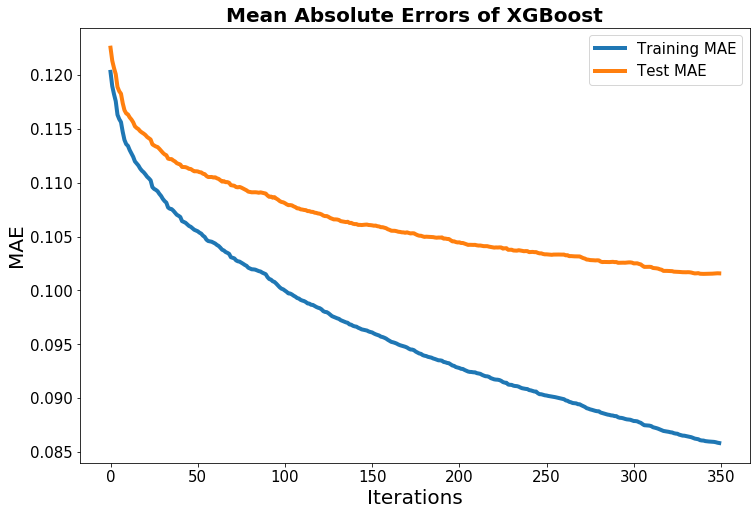

In [38]:
#MAE figure 
epochs = len(evals_result['Train']['mae'])
x_axis = range(0, epochs)

# plot rmse loss
fig, ax = plt.subplots(figsize=(12,8))
csfont = {'fontname':'DejaVu Sans'}
ax.plot(x_axis, evals_result['Train']['mae'], label='Training MAE',linewidth=4)
ax.plot(x_axis, evals_result['Test']['mae'], label='Test MAE',linewidth=4)
ax.legend(fontsize=15)
ax.tick_params(axis='both', which='major', labelsize=15)

plt.ylabel('MAE',fontsize=20,**csfont)
plt.xlabel('Iterations',fontsize=20,**csfont)
plt.title('Mean Absolute Errors of XGBoost',fontsize=20, fontweight='bold')
#plt.savefig('XGBOOST_MAE_.png', dpi=300, bbox_inches="tight")

plt.show()

In [39]:
num_boost_round = model.best_iteration + 1
evals_result_test={}
best_model = xgb.train(
    params,
    dtrain,
    num_boost_round=num_boost_round,
    evals=[(dtest, "Test")],evals_result = evals_result_test
)

[10:57:34] WARNING: /tmp/xgboost-20191007-44032-1f3rb3e/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	Test-mae:0.122526
[1]	Test-mae:0.121314
[2]	Test-mae:0.12064
[3]	Test-mae:0.120065
[4]	Test-mae:0.11888
[5]	Test-mae:0.118486
[6]	Test-mae:0.118255
[7]	Test-mae:0.117378
[8]	Test-mae:0.116726
[9]	Test-mae:0.116426
[10]	Test-mae:0.116332
[11]	Test-mae:0.116053
[12]	Test-mae:0.115858
[13]	Test-mae:0.115602
[14]	Test-mae:0.115227
[15]	Test-mae:0.115076
[16]	Test-mae:0.114968
[17]	Test-mae:0.11478
[18]	Test-mae:0.114656
[19]	Test-mae:0.114553
[20]	Test-mae:0.114423
[21]	Test-mae:0.114241
[22]	Test-mae:0.114124
[23]	Test-mae:0.114004
[24]	Test-mae:0.113555
[25]	Test-mae:0.113451
[26]	Test-mae:0.11336
[27]	Test-mae:0.113304
[28]	Test-mae:0.113142
[29]	Test-mae:0.112955
[30]	Test-mae:0.112774
[31]	Test-mae:0.112628
[32]	Test-mae:0.112548
[33]	Test-mae:0.112232
[34]	Test-mae:0.112185
[35]	Test-mae:0.112187
[36]	Test-mae:0.112057
[37]	Test-m

In [40]:
#results for training set
print("Training set")
mae= mean_absolute_error(best_model.predict(dtrain), y_train)
print("MAE",mae)
mse= mean_squared_error(best_model.predict(dtrain), y_train)
print("MSE", mse)
final_rmse = np.sqrt(mse)
print("RMSE",final_rmse)

print("Testing set")
#result for test set
mae= mean_absolute_error(best_model.predict(dtest), y_test)
print("MAE",mae)
mse= mean_squared_error(best_model.predict(dtest), y_test)
print("MSE",mse)
final_rmse = np.sqrt(mse)
print("RMSE",final_rmse)

Training set
MAE 0.08606358924505973
MSE 0.012909779692349608
RMSE 0.11362121145433016
Testing set
MAE 0.10153311329335651
MSE 0.018267971189714516
RMSE 0.13515905885183765


In [ ]:
best_model.save_model("best_xgboost_model.model")

### load model for future use (only have to run the following code to reproduce the xgboost model)

In [16]:
xgb_best_model = xgb.Booster()
xgb_best_model.load_model("best_xgboost_model.model")
# And use it for predictions.

[17:02:21] WARNING: /tmp/xgboost-20191007-44032-1f3rb3e/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


###### max_depth': 5, 'min_child_weight': 2, 'eta': 0.1, 'subsample': 1.0, 'colsample_bytree': 0.5, 'objective': 'reg:linear', 'eval_metric': 'mae'


In [17]:
#using the xgboost sklearn API. 
final_xgb_model = xgb.XGBRegressor(max_depth=5, min_child_weight =2,
                            subsample=1.0,
                            colsample_bytree= 0.5,eta = 0.1,random_state=42,n_jobs = -1)
                            #bootstrap=True, verbose=False)

final_xgb_model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)],
                    eval_metric=['rmse','mae'], verbose = True)

xbg_pred = final_xgb_model.predict(X_test)

print(xbg_pred)

[17:02:23] WARNING: /tmp/xgboost-20191007-44032-1f3rb3e/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:0.164796	validation_0-mae:0.120857	validation_1-rmse:0.168572	validation_1-mae:0.123175
[1]	validation_0-rmse:0.161465	validation_0-mae:0.119088	validation_1-rmse:0.165368	validation_1-mae:0.121472
[2]	validation_0-rmse:0.158576	validation_0-mae:0.117529	validation_1-rmse:0.162644	validation_1-mae:0.120042
[3]	validation_0-rmse:0.156716	validation_0-mae:0.116549	validation_1-rmse:0.160685	validation_1-mae:0.119032
[4]	validation_0-rmse:0.155632	validation_0-mae:0.116091	validation_1-rmse:0.15952	validation_1-mae:0.118589
[5]	validation_0-rmse:0.154405	validation_0-mae:0.115515	validation_1-rmse:0.158311	validation_1-mae:0.118068
[6]	validation_0-rmse:0.15255	validation_0-mae:0.11449	validation_1-rmse:0.156564	validation_1-mae:0.117141
[7]	validation_0-rmse:0.151322	validation_0-mae:0.113851	validation_1-rmse:0.1555

[73]	validation_0-rmse:0.13316	validation_0-mae:0.102023	validation_1-rmse:0.141827	validation_1-mae:0.108142
[74]	validation_0-rmse:0.133079	validation_0-mae:0.101959	validation_1-rmse:0.141816	validation_1-mae:0.108146
[75]	validation_0-rmse:0.13298	validation_0-mae:0.101872	validation_1-rmse:0.141758	validation_1-mae:0.108082
[76]	validation_0-rmse:0.132807	validation_0-mae:0.101675	validation_1-rmse:0.14161	validation_1-mae:0.107932
[77]	validation_0-rmse:0.132659	validation_0-mae:0.101571	validation_1-rmse:0.14155	validation_1-mae:0.107888
[78]	validation_0-rmse:0.132545	validation_0-mae:0.101492	validation_1-rmse:0.141524	validation_1-mae:0.107868
[79]	validation_0-rmse:0.132497	validation_0-mae:0.101457	validation_1-rmse:0.141516	validation_1-mae:0.107854
[80]	validation_0-rmse:0.132312	validation_0-mae:0.101308	validation_1-rmse:0.141394	validation_1-mae:0.107754
[81]	validation_0-rmse:0.132264	validation_0-mae:0.10127	validation_1-rmse:0.1414	validation_1-mae:0.107761
[82]	val

### Permutation importance XGB

In [23]:
xgb_permu =permu_importance(final_xgb_model, X_test,y_test, feature_names,n_iter = 200)


MSE          feature  feature_importance
0   z1_TRAF_COMP            0.010348
1   z2_TRAF_DENS            0.005140
2       z4_DELAY            0.002452
3  z3_RISK_INDEX            0.001139
4      Z5_RANDOM            0.000045
PI_std          feature  feature_importance
0   z1_TRAF_COMP            0.000450
1   z2_TRAF_DENS            0.000225
2       z4_DELAY            0.000156
3  z3_RISK_INDEX            0.000071
4      Z5_RANDOM            0.000031


# ANN

In [18]:
X_train_norm,X_test_norm = ANN_preprocess(X_train, X_test)

In [4]:
#k-cross validation 
from keras.callbacks import ModelCheckpoint,EarlyStopping

k = 4
EPOCHS = 200

#callback = EarlyStopping(monitor='val_loss', patience=2)
checkpoint =ModelCheckpoint(filepath='my_model.h5', monitor='val_loss', save_best_only=True)

num_val_samples = len(X_train_norm) // k 

#all_scores = []
all_mae_histories =[]
all_mse_histories=[]
for i in range(k):
    print('processing fold #',i+1)
    val_data = X_train_norm[i*num_val_samples:(i+1)*num_val_samples]
    val_target = y_train[i*num_val_samples:(i+1)*num_val_samples]
    
    partial_train_data = np.concatenate([X_train_norm[:i*num_val_samples],X_train_norm[(i+1)*num_val_samples:]],axis=0)
    partial_train_targets = np.concatenate( [y_train[:i * num_val_samples], y_train[(i + 1) * num_val_samples:]], axis=0)
    model = build_model_2()
    history = model.fit(partial_train_data, partial_train_targets,
                        validation_data=(val_data, val_target),
                        epochs=EPOCHS, batch_size=64, verbose=1,callbacks=[checkpoint])#,callback])
      
    mae_history = history.history['val_mean_absolute_error']
    all_mae = all_mae_histories.append(mae_history)
    
    mse_history = history.history['val_mean_squared_error']
    all_mse = all_mse_histories.append(mse_history)
    

processing fold # 1







Train on 12132 samples, validate on 4043 samples
Epoch 1/200





12132/12132 [==============================] - 1s 101us/step - loss: 0.0371 - mean_absolute_error: 0.1452 - mean_squared_error: 0.0371 - val_loss: 0.0258 - val_mean_absolute_error: 0.1225 - val_mean_squared_error: 0.0258
Epoch 2/200
12132/12132 [==============================] - 0s 27us/step - loss: 0.0261 - mean_absolute_error: 0.1212 - mean_squared_error: 0.0261 - val_loss: 0.0248 - val_mean_absolute_error: 0.1204 - val_mean_squared_error: 0.0248
Epoch 3/200
12132/12132 [==============================] - 0s 29us/step - loss: 0.0252 - mean_absolute_error: 0.1192 - mean_squared_error: 0.0252 - val_loss: 0.0229 - val_mean_absolute_error: 0.1160 - val_mean_squared_error: 0.0229
Epoch 4/200
12132/12132 [==============================] - 0s 28us/step - loss: 0.0244 - mean_absolute_error: 0.1175 - mean_squared_error: 0.0244 - val_loss: 0.0222 - val_mean_absolute_error: 0.1140 - val_mean_squared_erro

12132/12132 [==============================] - 0s 34us/step - loss: 0.0208 - mean_absolute_error: 0.1109 - mean_squared_error: 0.0208 - val_loss: 0.0202 - val_mean_absolute_error: 0.1089 - val_mean_squared_error: 0.0202
Epoch 61/200
12132/12132 [==============================] - 0s 34us/step - loss: 0.0208 - mean_absolute_error: 0.1109 - mean_squared_error: 0.0208 - val_loss: 0.0200 - val_mean_absolute_error: 0.1082 - val_mean_squared_error: 0.0200
Epoch 62/200
12132/12132 [==============================] - 0s 33us/step - loss: 0.0209 - mean_absolute_error: 0.1110 - mean_squared_error: 0.0209 - val_loss: 0.0199 - val_mean_absolute_error: 0.1101 - val_mean_squared_error: 0.0199
Epoch 63/200
12132/12132 [==============================] - 0s 32us/step - loss: 0.0208 - mean_absolute_error: 0.1112 - mean_squared_error: 0.0208 - val_loss: 0.0199 - val_mean_absolute_error: 0.1091 - val_mean_squared_error: 0.0199
Epoch 64/200
12132/12132 [==============================] - 0s 33us/step - loss: 

12132/12132 [==============================] - 0s 34us/step - loss: 0.0201 - mean_absolute_error: 0.1092 - mean_squared_error: 0.0201 - val_loss: 0.0203 - val_mean_absolute_error: 0.1105 - val_mean_squared_error: 0.0203
Epoch 131/200
12132/12132 [==============================] - 0s 36us/step - loss: 0.0203 - mean_absolute_error: 0.1099 - mean_squared_error: 0.0203 - val_loss: 0.0204 - val_mean_absolute_error: 0.1102 - val_mean_squared_error: 0.0204
Epoch 132/200
12132/12132 [==============================] - 0s 34us/step - loss: 0.0202 - mean_absolute_error: 0.1094 - mean_squared_error: 0.0202 - val_loss: 0.0205 - val_mean_absolute_error: 0.1109 - val_mean_squared_error: 0.0205
Epoch 133/200
12132/12132 [==============================] - 0s 35us/step - loss: 0.0202 - mean_absolute_error: 0.1095 - mean_squared_error: 0.0202 - val_loss: 0.0201 - val_mean_absolute_error: 0.1093 - val_mean_squared_error: 0.0201
Epoch 134/200
12132/12132 [==============================] - 0s 38us/step - lo

12132/12132 [==============================] - 0s 34us/step - loss: 0.0200 - mean_absolute_error: 0.1089 - mean_squared_error: 0.0200 - val_loss: 0.0204 - val_mean_absolute_error: 0.1109 - val_mean_squared_error: 0.0204
Epoch 166/200
12132/12132 [==============================] - 0s 35us/step - loss: 0.0199 - mean_absolute_error: 0.1087 - mean_squared_error: 0.0199 - val_loss: 0.0207 - val_mean_absolute_error: 0.1120 - val_mean_squared_error: 0.0207
Epoch 167/200
12132/12132 [==============================] - 0s 36us/step - loss: 0.0200 - mean_absolute_error: 0.1088 - mean_squared_error: 0.0200 - val_loss: 0.0211 - val_mean_absolute_error: 0.1137 - val_mean_squared_error: 0.0211
Epoch 168/200
12132/12132 [==============================] - 0s 35us/step - loss: 0.0199 - mean_absolute_error: 0.1089 - mean_squared_error: 0.0199 - val_loss: 0.0201 - val_mean_absolute_error: 0.1094 - val_mean_squared_error: 0.0201
Epoch 169/200
12132/12132 [==============================] - 0s 33us/step - lo

KeyError: 'val_mae'

In [12]:
mae_history = history.history['val_mean_absolute_error']
all_mae = all_mae_histories.append(mae_history)
    
mse_history = history.history['val_mean_squared_error']
all_mse = all_mse_histories.append(mse_history)

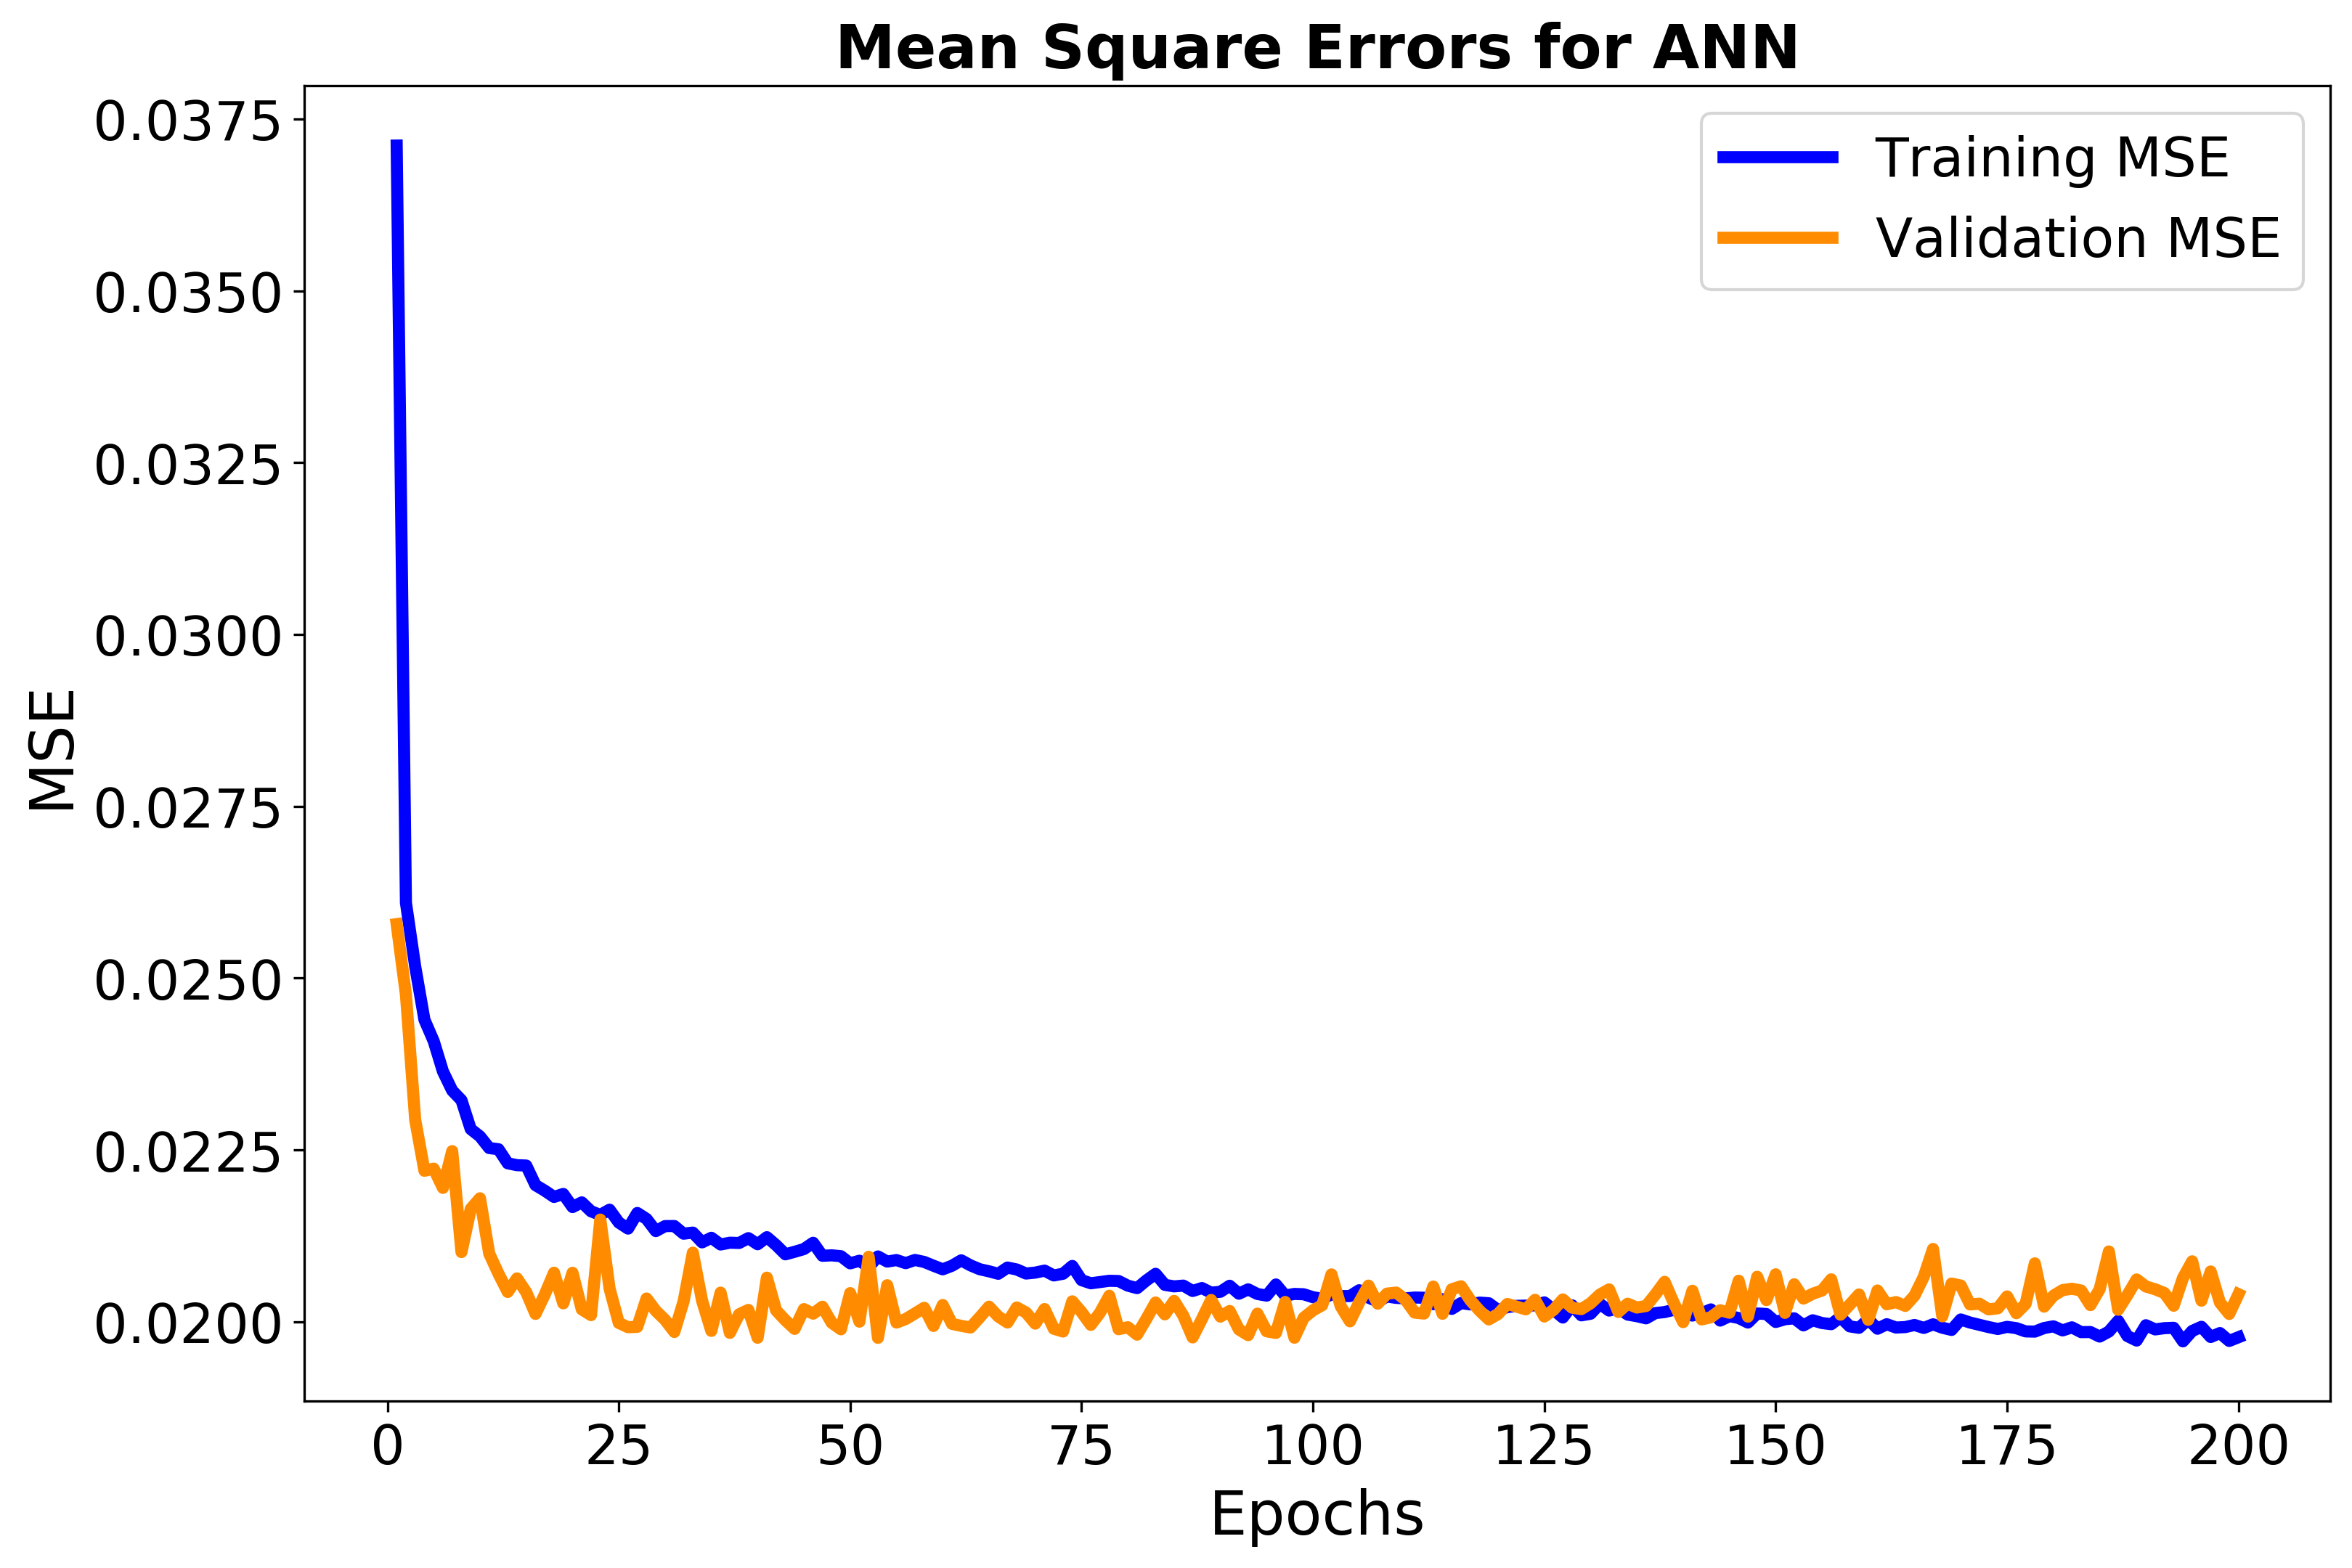

In [10]:
import matplotlib.pyplot as plt

loss = history.history['mean_squared_error'] 
val_loss = history.history['val_mean_squared_error']

epochs = range(1, len(loss) + 1)
plt.figure(figsize=(12, 8), dpi=300)
plt.tick_params(axis='both', which='major', labelsize=18)

plt.plot(epochs, loss, 'b', label='Training MSE',linewidth=4) 
plt.plot(epochs, val_loss, 'darkorange', label='Validation MSE',linewidth=4) 
plt.title('Mean Square Errors for ANN', fontsize=20, fontweight='bold') 
plt.xlabel('Epochs', fontsize=20)#, fontweight='bold') 
plt.ylabel('MSE', fontsize=20)#, fontweight='bold') 
plt.legend(prop={'size': 18})
plt.show()
#plt.savefig('training_ANN_mse.png')
#files.download('training_ANN_mse.png')

In [13]:
average_mae_history = np.round([ np.mean([x[i] for x in all_mae_histories]) for i in range(EPOCHS)],5)
print("average mae",average_mae_history)
average_mse_history = np.round([ np.mean([x[i] for x in all_mse_histories]) for i in range(EPOCHS)],5)
print("average mse",average_mse_history)

average mae [0.12251 0.12037 0.11597 0.11401 0.11249 0.11362 0.11665 0.11187 0.11463
 0.11712 0.1115  0.11091 0.11009 0.10943 0.1102  0.1093  0.11142 0.10988
 0.10882 0.11171 0.1109  0.10911 0.1169  0.11284 0.10901 0.10966 0.10851
 0.10934 0.11097 0.10936 0.10932 0.11112 0.1149  0.10976 0.1097  0.1117
 0.10927 0.10879 0.10975 0.10897 0.10936 0.11148 0.10923 0.10887 0.11177
 0.11081 0.10931 0.1096  0.10978 0.11207 0.10942 0.11399 0.10883 0.11038
 0.1101  0.10899 0.10997 0.10888 0.10974 0.10885 0.10818 0.11006 0.10908
 0.10881 0.10884 0.11059 0.11053 0.11174 0.11104 0.11036 0.10938 0.10972
 0.10882 0.11095 0.111   0.10876 0.10911 0.11184 0.10937 0.10854 0.10883
 0.11056 0.11175 0.10917 0.10879 0.10942 0.1088  0.10867 0.10946 0.10971
 0.11124 0.10905 0.10865 0.11036 0.10859 0.10878 0.11128 0.10787 0.10873
 0.10881 0.11006 0.11322 0.10988 0.10903 0.10989 0.11019 0.10965 0.11199
 0.11234 0.11188 0.10902 0.1095  0.11204 0.10954 0.11207 0.11129 0.11158
 0.11035 0.10881 0.11008 0.1106  0.11016

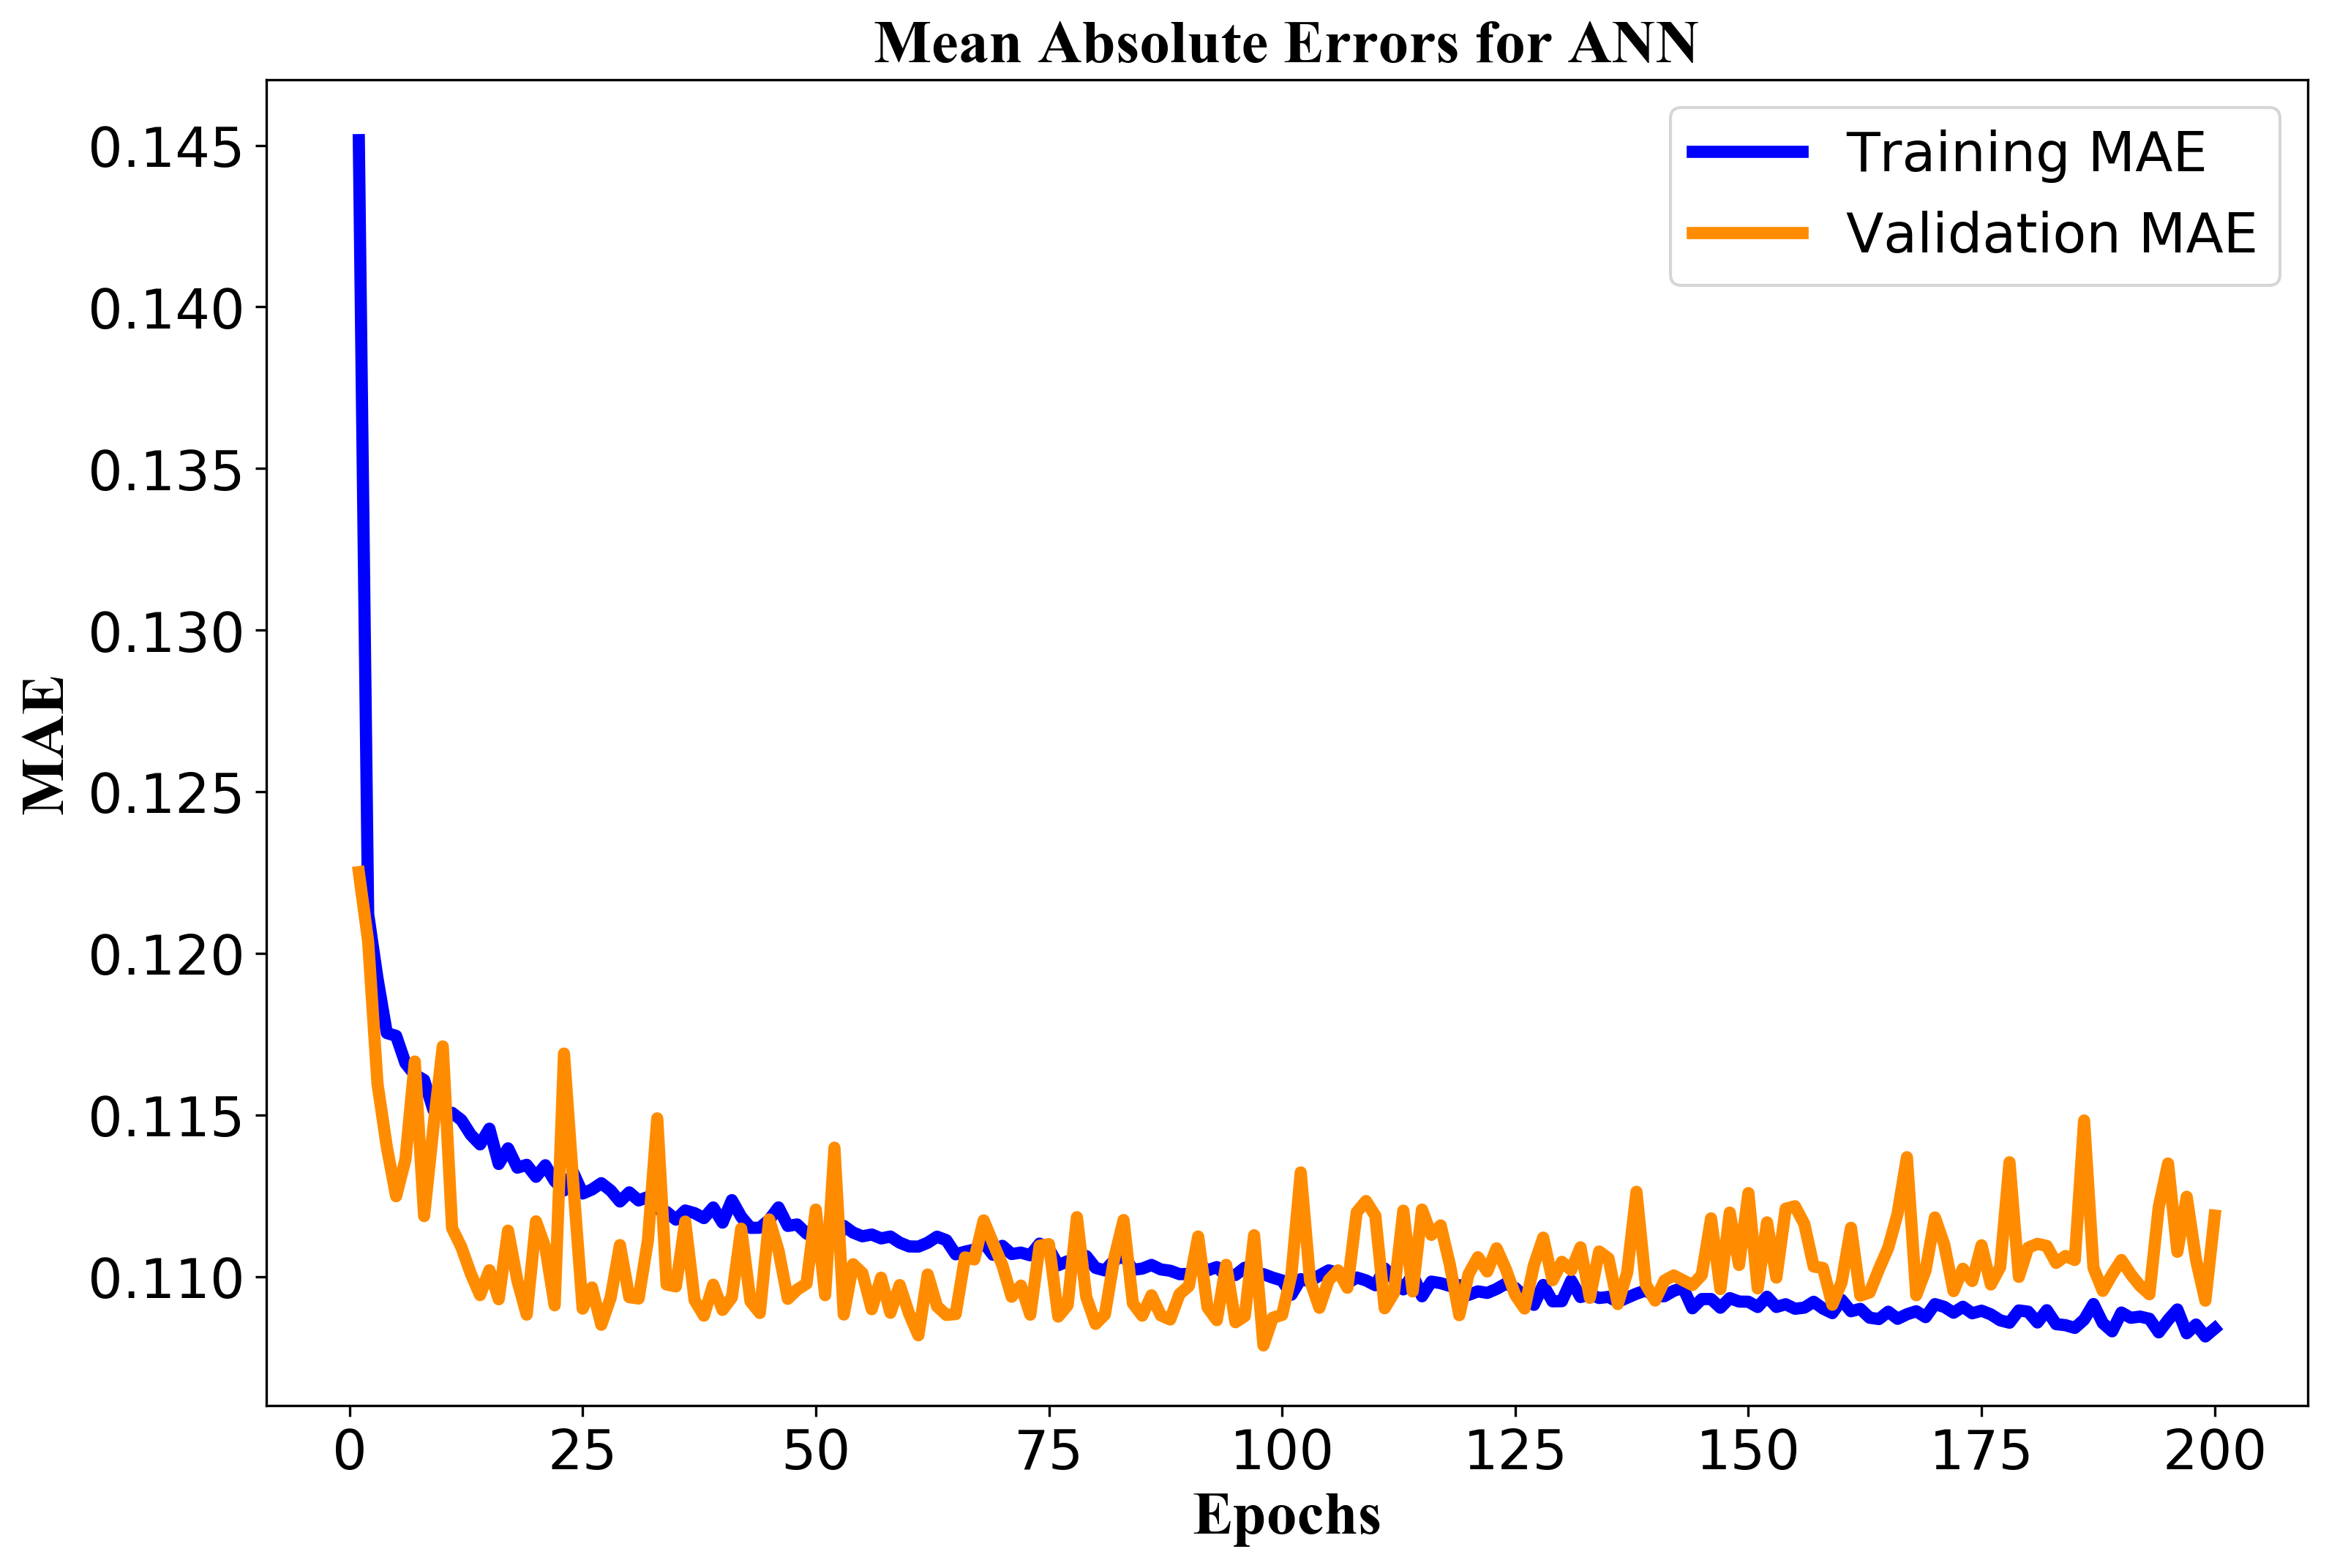

In [14]:
import matplotlib.pyplot as plt

loss = history.history['mean_absolute_error'] 
val_loss = history.history['val_mean_absolute_error']

epochs = range(1, len(loss) + 1)
csfont = {'fontname':'Times New Roman'}
# plt.rcParams['font.sans-serif'] = "Times New Roman"
plt.figure(figsize=(12, 8), dpi=300)
plt.tick_params(axis='both', which='major', labelsize=18)

plt.plot(epochs, loss, 'b', label='Training MAE',linewidth=4) 
plt.plot(epochs, val_loss, 'darkorange', label='Validation MAE',linewidth=4) 
plt.title('Mean Absolute Errors for ANN', fontsize=20, fontweight='bold',**csfont) 
plt.xlabel('Epochs', fontsize=20,**csfont)#, fontweight='bold') 
plt.ylabel('MAE', fontsize=20,**csfont)#, fontweight='bold') 
plt.legend(prop={'size': 18})
plt.show()
#plt.savefig('training_ANN_mae.png')
#files.download('training_ANN_mae.png')

In [19]:
#testing on the final model
model= build_model_2()
model.fit(X_train_norm, y_train, epochs =75, batch_size = 64)


result = model.evaluate(X_test_norm, y_test, verbose=0)
print("loss, test_mae_value,test_mse_value:", np.round(result,5))








Epoch 1/75





16175/16175 [==============================] - 1s 74us/step - loss: 0.0471 - mean_absolute_error: 0.1606 - mean_squared_error: 0.0471
Epoch 2/75
16175/16175 [==============================] - 0s 23us/step - loss: 0.0256 - mean_absolute_error: 0.1205 - mean_squared_error: 0.0256
Epoch 3/75
16175/16175 [==============================] - 0s 23us/step - loss: 0.0245 - mean_absolute_error: 0.1182 - mean_squared_error: 0.0245
Epoch 4/75
16175/16175 [==============================] - 0s 24us/step - loss: 0.0241 - mean_absolute_error: 0.1174 - mean_squared_error: 0.0241
Epoch 5/75
16175/16175 [==============================] - 0s 24us/step - loss: 0.0236 - mean_absolute_error: 0.1164 - mean_squared_error: 0.0236
Epoch 6/75
16175/16175 [==============================] - 0s 24us/step - loss: 0.0233 - mean_absolute_error: 0.1159 - mean_squared_error: 0.0233
Epoch 7/75
16175/16175 [==============================] - 0s 24us/step - loss: 0.0230 - mean_absolute_error: 0.1153 - 

In [20]:
result_train = model.evaluate(X_train_norm, y_train, verbose=0)
print("loss, train_mae_value,train_mse_value:", np.round(result_train,5))

loss, train_mae_value,train_mse_value: [0.02001 0.10905 0.02001]


### Permutation importance ANN

In [21]:
# def ann_score(X,y):
#     y_pred = model.predict(X)
#     return mean_absolute_error(y, y_pred)
def ann_score(X,y):
    y_pred = model.predict(X)
    return mean_squared_error(y, y_pred)

base_score, score_decreases = get_score_importances(ann_score,np.array(X_test_norm),y_test, n_iter=200, random_state=42)
ann_permu_avg = np.mean(score_decreases, axis=0)
ann_permu_std = np.std(score_decreases, axis=0)
for i in range(len(score_decreases)):
    score_decreases[i] = -1* score_decreases[i]

    
print(-ann_permu_avg)
print(ann_permu_std)
    
print(score_decreases)

[1.40591504e-02 6.29515765e-03 3.83683262e-04 3.44518402e-03
 3.96845765e-05]
[6.55608264e-04 3.55059761e-04 1.10002679e-04 2.29480366e-04
 8.49576126e-05]
[array([1.39296478e-02, 6.51171836e-03, 2.85985914e-04, 3.22205812e-03,
       4.84906458e-05]), array([0.01330585, 0.00642911, 0.00047516, 0.00345248, 0.00023191]), array([ 1.48101168e-02,  6.39893157e-03,  2.14176961e-04,  3.27894590e-03,
       -1.14590324e-05]), array([1.31525550e-02, 6.24358865e-03, 2.94859403e-04, 3.24500709e-03,
       3.42492317e-05]), array([1.48818867e-02, 6.24135266e-03, 3.09278638e-04, 3.47741213e-03,
       7.06181368e-05]), array([1.32659029e-02, 5.69282806e-03, 3.85860068e-04, 3.38569305e-03,
       4.31668729e-05]), array([1.38825079e-02, 6.64017799e-03, 6.43223983e-04, 3.57466876e-03,
       9.59053588e-05]), array([ 0.01466193,  0.00632563,  0.00014307,  0.0039056 , -0.00013454]), array([1.42315652e-02, 5.95595667e-03, 5.20783454e-04, 3.95049187e-03,
       6.98848260e-05]), array([0.0137326 , 0.00

In [22]:
PI_mean = imp_df(feature_names[0:5], -ann_permu_avg)
print('MSE',PI_mean)
PI_std =imp_df(feature_names[0:5],ann_permu_std)
print('PI_std',PI_std)

MSE          feature  feature_importance
0   z1_TRAF_COMP            0.014059
1   z2_TRAF_DENS            0.006295
2       z4_DELAY            0.003445
3  z3_RISK_INDEX            0.000384
4      Z5_RANDOM            0.000040
PI_std          feature  feature_importance
0   z1_TRAF_COMP            0.000656
1   z2_TRAF_DENS            0.000355
2       z4_DELAY            0.000229
3  z3_RISK_INDEX            0.000110
4      Z5_RANDOM            0.000085


# Permutation Importance 

In [2]:
feature_no =('Z1 Traffic Complexity','Z2 Traffic Density','Z3 Fatigue Level','Z4 Delay','*Random')

perm_imp_SVM = pd.DataFrame(data=svm_permu_import.results_,columns=feature_no)

perm_imp_xgb = pd.DataFrame(data=xgb_permu.results_,columns=feature_no)

perm_imp_rf = pd.DataFrame(data=rf_permu.results_,columns=feature_no)

perm_imp_ANN = pd.DataFrame(data=score_decreases,columns=feature_no)

#sort the dataframe 

data1 = perm_imp_rf.assign(Model ='RF')
data2 = perm_imp_ANN.assign(Model='ANN')
data3 = perm_imp_xgb.assign(Model = 'XGboost')
data4 = perm_imp_SVM.assign(Model = 'SVM')

df_permu = pd.concat([data1, data2, data3,data4])    

df_permu_final = pd.melt(df_permu, id_vars=['Model'], var_name=['feature_names'])
print(df_permu_final)

NameError: name 'pd' is not defined

In [1]:
df_permu_final.to_excel("final_permu_result.xlsx")

NameError: name 'df_permu_final' is not defined

Text(0.5, 0, 'Permutation Importance (MSE)')

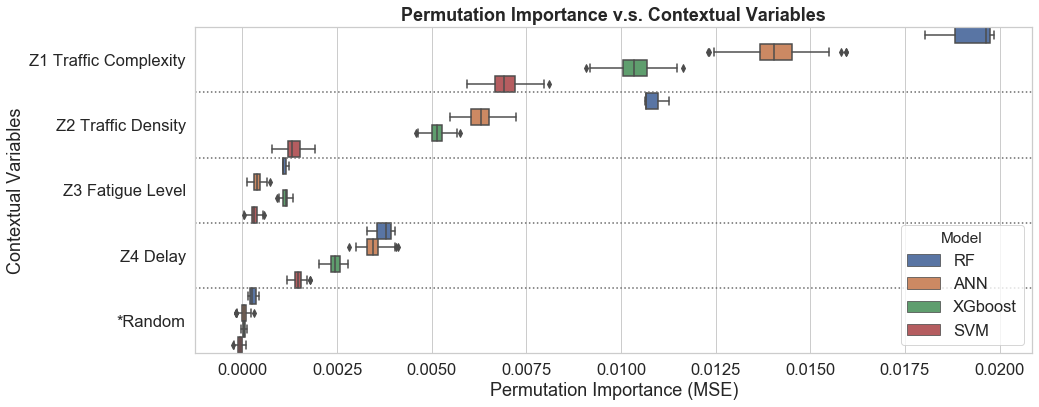

In [26]:
feature_no =('Z1 Traffic Complexity','Z2 Traffic Density','Z3 Fatigue Level','Z4 Delay','*Random')

plt.figure(figsize=(15,6))
sns.set(font_scale = 1.5,style="whitegrid")
sns.boxplot(y="feature_names", x="value",hue="Model",orient="h", data=df_permu_final,width=1)
plt.axhline(0.5,ls=':',color='dimgray')
plt.axhline(1.5,ls=':',color='dimgray')
plt.axhline(2.5,ls=':',color='dimgray')
plt.axhline(3.5,ls=':',color='dimgray')

plt.title('Permutation Importance v.s. Contextual Variables', weight='bold')#, fontsize=30)
plt.ylabel('Contextual Variables')#,weight='bold', fontsize=23)
plt.xlabel('Permutation Importance (MSE)')#,weight='bold', fontsize=23)
#plt.savefig('Permu image_Aug8.png', dpi=600, bbox_inches="tight")

#%